In [ ]:
%pip install sklearn-pandas


In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sklearn
from copy import deepcopy
from matplotlib.cm import CMRmap
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [2]:
#df=pd.read_csv("ks-projects-201801.csv")

#base data
#x_test_base=pd.read_csv("./data/preprocess-base-x-test.csv")
x_train_base=pd.read_csv("./data/preprocess-base-x-train.csv")
y_train_base=pd.read_csv("./data/preprocess-base-y-train.csv")
x_valid_base=pd.read_csv("./data/preprocess-base-x-valid.csv")
y_valid_base=pd.read_csv("./data/preprocess-base-y-valid.csv")

#basic_name data
#x_test_basic_name=pd.read_csv("./data/preprocess-basic_name-x-test-correct.csv")
x_train_basic_name=pd.read_csv("./data/preprocess-basic_name-x-train-correct.csv").rename(columns={"launched_month_deadline_month_0": "launched_month", "launched_month_deadline_month_1": "deadline_month"}).drop(columns=['Unnamed: 0.1'])
y_train_basic_name=pd.read_csv("./data/preprocess-basic_name-y-train-correct.csv").rename(columns={'1':'success'})
x_valid_basic_name=pd.read_csv("./data/preprocess-basic_name-x-valid-correct.csv").rename(columns={"launched_month_deadline_month_0": "launched_month", "launched_month_deadline_month_1": "deadline_month"}).drop(columns=['Unnamed: 0.1'])
y_valid_basic_name=pd.read_csv("./data/preprocess-basic_name-y-valid-correct.csv").rename(columns={'1':'success'})

#doc2vec data
#x_test_doc2vec=pd.read_csv("./data/preprocess-doc2vec-x-test.csv")
x_train_doc2vec=pd.read_csv("./data/preprocess-doc2vec-x-train.csv")
y_train_doc2vec=pd.read_csv("./data/preprocess-doc2vec-y-train.csv")
x_valid_doc2vec=pd.read_csv("./data/preprocess-doc2vec-x-valid.csv")
y_valid_doc2vec=pd.read_csv("./data/preprocess-doc2vec-y-valid.csv")



In [3]:
def one_hot_df(df,one_hot_cols,drop_cols):
    dfret=deepcopy(df)
    #dfret.astype({'launched_month': 'int32'})
    dfret=pd.get_dummies(dfret,columns=one_hot_cols).drop(columns=drop_cols)
    return dfret


def cast_to_nparray(dataset,one_hot_cols,drop_cols):
    dataset['x_train']=one_hot_df(dataset['x_train'], one_hot_cols,drop_cols)
    dataset['x_valid']=one_hot_df(dataset['x_valid'],one_hot_cols,drop_cols)
    #x_test=one_hot_df(x_test,one_hot_cols,drop_cols)
    
    dataset['x_train']=np.array(dataset['x_train'])
    dataset['x_valid']=np.array(dataset['x_valid'])
    #x_test=np.array(x_test)
    
    dataset['y_train']=np.array(dataset['y_train']['success'])
    dataset['y_valid']=np.array(dataset['y_valid']['success'])
    return dataset

In [4]:
def report_results(model, X, y):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return [result, pred, model.feature_importances_]

In [32]:
datasets={}
#'x_test':x_test_base,
datasets['base']={ 'x_train': x_train_base,'y_train':y_train_base,'x_valid':x_valid_base,'y_valid':y_valid_base}
#'x_test':x_test_basic_name,
datasets['basic_name']={'x_train': x_train_basic_name,'y_train':y_train_basic_name,'x_valid':x_valid_basic_name,'y_valid':y_valid_basic_name}
#'x_test':x_test_doc2vec,
datasets['doc2vec']={ 'x_train': x_train_doc2vec,'y_train':y_train_doc2vec,'x_valid':x_valid_doc2vec,'y_valid':y_valid_doc2vec}


dataset_keys=['base','basic_name','doc2vec']
one_hot_cols=['main_category','category','launched_month','deadline_month']
drop_cols=['Unnamed: 0']

for key in dataset_keys:
    datasets[key]=cast_to_nparray(datasets[key], one_hot_cols, drop_cols)


x=1
num_estimators=[1]
for i in range(10):
    x*=2
    num_estimators+=[x]
    
print(num_estimators)

data = np.full((len(datasets),len(max_depths),len(num_estimators)), 'e').tolist()

#####################################################################
max_acc_arg=[]
max_acc=0
max_depths=[1,2,3]
for i in range(len(dataset_keys)):        
    for j in range(len(max_depths)):
        for k in range(len(num_estimators)):
            model=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1) ,n_estimators=num_estimators[k], random_state=42)
            model.fit(datasets[dataset_keys[i]]['x_train'],datasets[dataset_keys[i]]['y_train'])
            res=report_results(model,datasets[dataset_keys[i]]['x_valid'],datasets[dataset_keys[i]]['y_valid'])
            if res[0]['acc']>max_acc:
                max_acc=res[0]['acc']
                max_acc_arg=[i,j,k]
                dbfile = open('best_Adaboost', 'wb')
                pickle.dump((max_acc,max_acc_arg,model), dbfile)                      
                dbfile.close()
#             dbfile = open('data_Adaboost', 'wb')
#             pickle.dump(res, dbfile)                      
#             dbfile.close()
            data[i][j][k]=res
            print("%2d,%2d,%2d" % (i,j,k))
        
dbfile = open('data_AdaBoost', 'wb')
pickle.dump(data, dbfile)                      
dbfile.close()
#######################################################################

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 0, 0, 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 0, 0, 1
 0, 0, 2
 0, 0, 3
 0, 0, 4
 0, 0, 5
 0, 0, 6
 0, 0, 7
 0, 0, 8
 0, 0, 9
 0, 0,10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 0, 1, 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 0, 1, 1
 0, 1, 2
 0, 1, 3
 0, 1, 4
 0, 1, 5
 0, 1, 6
 0, 1, 7
 0, 1, 8
 0, 1, 9
 0, 1,10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 0, 2, 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 0, 2, 1
 0, 2, 2
 0, 2, 3
 0, 2, 4
 0, 2, 5
 0, 2, 6
 0, 2, 7
 0, 2, 8
 0, 2, 9
 0, 2,10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 1, 0, 0
 1, 0, 1
 1, 0, 2
 1, 0, 3
 1, 0, 4
 1, 0, 5
 1, 0, 6
 1, 0, 7
 1, 0, 8
 1, 0, 9
 1, 0,10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 1, 1, 0
 1, 1, 1
 1, 1, 2
 1, 1, 3
 1, 1, 4
 1, 1, 5
 1, 1, 6
 1, 1, 7
 1, 1, 8
 1, 1, 9
 1, 1,10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 1, 2, 0
 1, 2, 1
 1, 2, 2
 1, 2, 3
 1, 2, 4
 1, 2, 5
 1, 2, 6
 1, 2, 7
 1, 2, 8
 1, 2, 9
 1, 2,10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 2, 0, 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 2, 0, 1
 2, 0, 2
 2, 0, 3
 2, 0, 4
 2, 0, 5
 2, 0, 6
 2, 0, 7
 2, 0, 8
 2, 0, 9
 2, 0,10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 2, 1, 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 2, 1, 1
 2, 1, 2
 2, 1, 3
 2, 1, 4
 2, 1, 5
 2, 1, 6
 2, 1, 7
 2, 1, 8
 2, 1, 9
 2, 1,10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 2, 2, 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 2, 2, 1
 2, 2, 2
 2, 2, 3
 2, 2, 4
 2, 2, 5
 2, 2, 6
 2, 2, 7
 2, 2, 8
 2, 2, 9
 2, 2,10


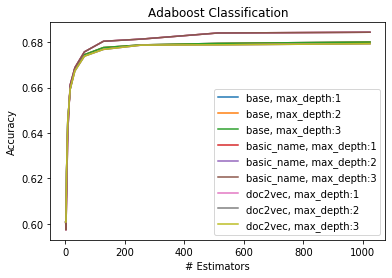

In [36]:
labels=[]
accuracies=[]
for i in range(len(dataset_keys)):        
    for j in range(len(max_depths)):
        labels.append(dataset_keys[i]+', max_depth:'+str(j+1))
        accs=[]
        for k in range(len(num_estimators)):
            accs.append(data[i][j][k][0]['acc'])
        accuracies.append(accs)
    
# for i in range(len(dataset_keys)):        
#     for j in range(len(max_depths)):
#         for k in range(len(num_estimators)):
#             print(data[i][j][k][0]['acc'])
        
fig=plt.figure()
for i in range(len(accuracies)):
    plt.plot(num_estimators,accuracies[i],label=labels[i])
plt.legend()
plt.title('Adaboost Classification')
plt.ylabel('Accuracy')
plt.xlabel('# Estimators')
#plt.xlim(.639,.641)
plt.show()

9


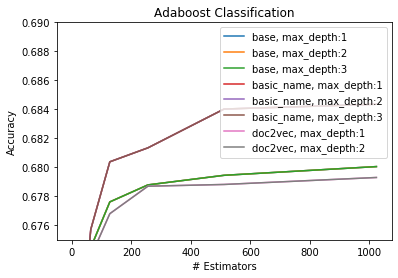

In [47]:
fig=plt.figure()
print(len(accuracies))
for i in range(len(accuracies[:8])):
    plt.plot(num_estimators,accuracies[i],label=labels[i])
plt.legend()
plt.title('Adaboost Classification')
plt.ylabel('Accuracy')
plt.xlabel('# Estimators')
plt.ylim(.675,.69)
plt.show()

9


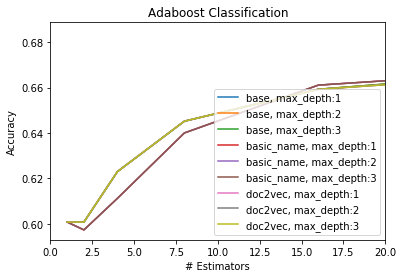

In [50]:
fig=plt.figure()
print(len(accuracies))
for i in range(len(accuracies)):
    plt.plot(num_estimators,accuracies[i],label=labels[i])
plt.legend()
plt.title('Adaboost Classification')
plt.ylabel('Accuracy')
plt.xlabel('# Estimators')
plt.xlim(0,20)
#plt.ylim(0,.5)
plt.show()

In [58]:
dbfile = open('data_Adaboost', 'rb')
data = pickle.load(dbfile)
dbfile.close()
models=[0,0,0]
for i in range(len(dataset_keys)):
    best_model=0
    best=0
    for j in range(len(max_depths)):
        for k in range(len(num_estimators)):
            if best<data[i][j][k][0]['acc']:
                best_model=[i,j,k]
    models[i]=best_model

In [5]:
one_hot_cols=['main_category','category','launched_month','deadline_month']
drop_cols=['Unnamed: 0']

def cast_test_to_array(df,one_hot_cols,drop_cols):
    return np.array(pd.get_dummies(df,columns=one_hot_cols).drop(columns=drop_cols))

x_full_train_base=cast_test_to_array(x_train_base.append(x_valid_base),one_hot_cols,drop_cols)
x_full_train_basic=cast_test_to_array(x_train_basic_name.append(x_valid_basic_name),one_hot_cols,drop_cols)
x_full_train_doc2vec=cast_test_to_array(x_train_doc2vec.append(x_valid_doc2vec),one_hot_cols,drop_cols)
y_full_train=np.array(y_train_base.append(y_valid_base)['success'])

y_test=np.array(pd.read_csv("./data/preprocess-base-y-test.csv")['success'])
x_test_base=cast_test_to_array(pd.read_csv("./data/preprocess-base-x-test.csv"),one_hot_cols,drop_cols)
x_test_basic_name=cast_test_to_array(pd.read_csv("./data/preprocess-basic_name-x-test-correct.csv").rename(columns={"launched_month_deadline_month_0": "launched_month", "launched_month_deadline_month_1": "deadline_month"}).drop(columns=['Unnamed: 0.1']),one_hot_cols,drop_cols)
x_test_doc2vec=cast_test_to_array(pd.read_csv("./data/preprocess-doc2vec-x-test.csv"),one_hot_cols,drop_cols)


In [6]:
x=1
num_estimators=[1]
for i in range(10):
    x*=2
    num_estimators+=[x]
    
res=[]
trains=[x_full_train_base,x_full_train_basic,x_full_train_doc2vec]
tests=[x_test_base,x_test_basic_name,x_test_doc2vec]
for i in range(len(trains)):
    model=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1) ,n_estimators=num_estimators[10], random_state=42)
    model.fit(trains[i],y_full_train)
    res.append(report_results(model,tests[i],y_test))
print(res)

[[{'f1': 0.5645130446660293, 'acc': 0.6812246285520027, 'precision': 0.6313859692006845, 'recall': 0.5104490884837706}, array([False,  True, False, ...,  True,  True, False]), array([0.55664062, 0.26367188, 0.        , 0.00097656, 0.00097656,
       0.00292969, 0.00097656, 0.00097656, 0.00097656, 0.00195312,
       0.        , 0.00488281, 0.00195312, 0.        , 0.        ,
       0.        , 0.00097656, 0.00097656, 0.00097656, 0.00097656,
       0.00097656, 0.00097656, 0.00097656, 0.00097656, 0.00097656,
       0.00195312, 0.        , 0.00097656, 0.00097656, 0.00292969,
       0.00097656, 0.        , 0.        , 0.00097656, 0.00097656,
       0.00097656, 0.        , 0.00097656, 0.00097656, 0.00097656,
       0.00097656, 0.00097656, 0.00097656, 0.00097656, 0.00097656,
       0.00097656, 0.        , 0.00097656, 0.00097656, 0.        ,
       0.00097656, 0.00097656, 0.00097656, 0.00292969, 0.00195312,
       0.00097656, 0.00097656, 0.00097656, 0.00097656, 0.00097656,
       0.00097656, 0

In [10]:
print('base: ',res[0][0]['acc'])
print('basic_name: ',res[1][0]['acc'])
print('doc2vec: ',res[2][0]['acc'])

base:  0.6812246285520027
basic_name:  0.6879636850840882
doc2vec:  0.6840842282080509


In [70]:

model_base=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=models[0][1]) ,n_estimators=num_estimators[models[0][2]], random_state=42)
model_base.fit(x_full_train_base,y_full_train)
print(i)
model_basic=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=models[1][1]) ,n_estimators=num_estimators[models[1][2]], random_state=42)
model_basic.fit(x_full_train_basic,y_full_train)
print(i)
model_doc2vec=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=models[2][1]) ,n_estimators=num_estimators[models[2][2]], random_state=42)
model_doc2vec.fit(x_full_train_doc2vec,y_full_train)
print(i)

MemoryError: 

In [57]:
res_base=report_results(model_base,x_test_base,y_test)
res_basic=report_results(model_basic,x_test_basic_name,y_test)
res_doc2vec=report_results(model_doc2vec,x_test_doc2vec,y_test)
print(res_base[0]['acc'])
print(res_basic[0]['acc'])
print(res_doc2vec[0]['acc'])

ValueError: Number of features of the model must match the input. Model n_features is 203 and input n_features is 200 

In [ ]:

def comparePredictions(predictions,modelNames):
    l={}
    n_pred=len(predictions[0])
    for i,n1 in zip(predictions,modelNames):
        for j,n2 in zip(predictions,modelNames):
            c=0
            for k in range(n_pred):
                if predictions[i]!=predictions[j]:
                    c+=1
            l[n1+' '+n2]=c/l
    return l